In [ ]:
using Plots
using LinearAlgebra

In [ ]:
function solver1_rk4_step(t::Float64, y::Float64, step::Float64, f::Function)::Float64
    k1 = step * f(t, y)
    k2 = step * f(t + 0.5 * step, y + 0.5 * k1)
    k3 = step * f(t + 0.5 * step, y + 0.5 * k2)
    k4 = step * f(t + step, y + k3)
    
    return y + (k1 + 2 * k2 + 2 * k3 + k4) / 6
end

function solver1(
    t0::Float64, y0::Float64, step::Float64,  steps::Int64, 
    f::Function, solver1_step::Function
)
    t = zeros(steps); t[1] = t0
    y = zeros(steps); y[1] = y0
    
    for i = 2:steps
        t[i] = t0 + step * (i - 1)
        y[i] = solver1_step(t[i-1], y[i-1], step, f)
    end
    
    return (t, y)
end

solver1 (generic function with 1 method)

In [ ]:
function f0(t, y) 0.5 * y end

t0, y0 = solver1(0.0, 1.0, 0.5, 10, f0, solver1_rk4_step)

([0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5], [1.0, 1.2840169270833333, 1.648699469036526, 2.1169580259162033, 2.718209939201323, 3.4902275733006567, 4.481511283491029, 5.7543363469174365, 7.388665273572861, 9.487171279820362])

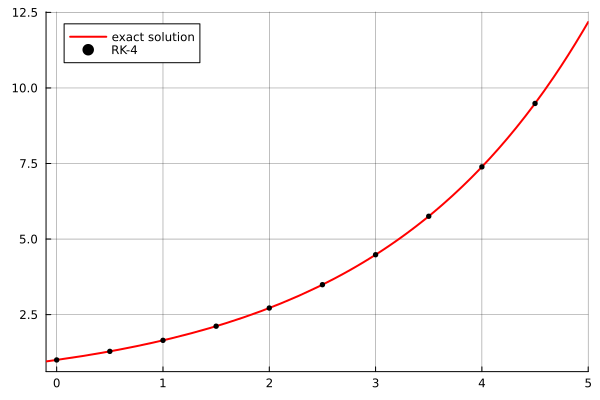

In [ ]:
plot(
    x -> exp(0.5 * x),
    gridalpha = 0.5,
    label = "exact solution",
    xlimits = (-0.1, 5),
    linewidth = 2,
    color = :red
)

scatter!(
    t0, y0,
    label = "RK-4",
    color = :black,
    markersize = 3,
    markerstrokewidth = 0
)

In [ ]:
function ssolve_rk4(
    t0::Float64, y0::Vector{Float64}, step::Float64,  steps::Int64, 
    fs::Function # fs must return a vector of length n_var
)
    n_var = length(y0)
    
    t = zeros(steps); t[1] = t0
    y = zeros(n_var, steps); y[:,1] = y0
    
    for i = 2:steps
        t[i] = t0 + step * (i-1)
        y_prev = y[:,i-1]
        
        k1 = step .* fs(t[i], y_prev)
        k2 = step .* fs(t[i] + 0.5 * step, y_prev + 0.5 * k1)
        k3 = step .* fs(t[i] + 0.5 * step, y_prev + 0.5 * k2)
        k4 = step .* fs(t[i] + step, y_prev + k3)
        
        y[:,i] = @. y_prev + (k1 + 2 * k2 + 2 * k3 + k4) / 6
    end
    
    return (t, y)
end

ssolve_rk4 (generic function with 1 method)

### Dampened harmonic oscillator

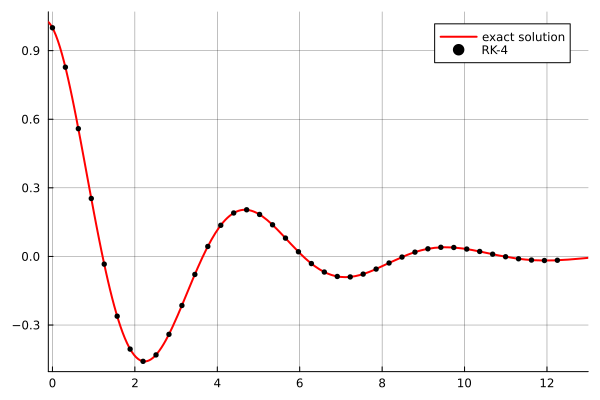

In [ ]:
w = 4 / 3
g = 1 / 3

dho(t, y) = [
    y[2],
    - w ^ 2 * y[1] - 2 * g * y[2]
]

t0 = 0.0; y0 = [1.0, -1 / 3]

t, y = ssolve_rk4(t0, y0, pi / 10, 40, dho)

p1 = plot(
    t -> exp(-g * t) * cos(sqrt(w ^ 2 - g ^ 2) * t),
    gridalpha = 0.5,
    label = "exact solution",
    xlimits = (-0.1, 13),
    linewidth = 2,
    color = :red
)

scatter!(
    t, y[1,:],
    label = "RK-4",
    color = :black,
    markersize = 3,
    markerstrokewidth = 0
)
# savefig(p1, "img/rk4-dho.png")

### Magnetic field

$$\vec r(t) = r\big(\cos(\omega t + \phi_0)\hat x + \sin(\omega t + \phi_0)\hat y\big) + v_{0,z} t\hat z + \vec r_c$$
$$
\begin{align}
\omega &= -Bq\\
\phi_0 &= -\arctan\Big(\frac{v_{0,x}}{v_{0,y}}\Big)\\
r &= \frac{1}{Bq}\sqrt{v_{0,x}^2 + v_{0,y}^2}\\
\vec r_c &= \vec r_0 + \frac{1}{Bq}(v_{0,y}\hat x - v_{0,x}\hat y)
\end{align}
$$

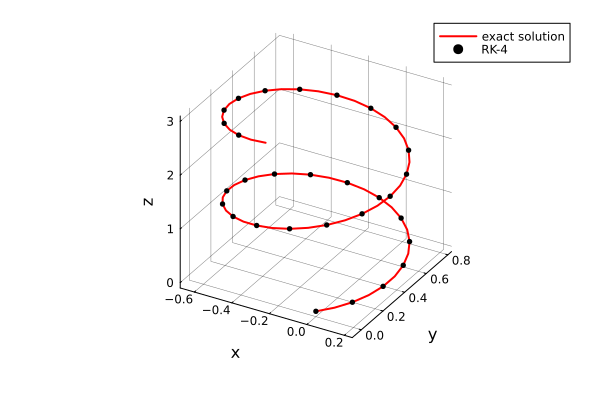

In [18]:
B0 = 4
B = [0, 0, B0] # magnetic field
q = -1 # charge
m = 1 # mass

r0 = zeros(3) # initial position
theta = pi / 3; phi = pi / 6
v0 = 2 * [sin(theta) * cos(phi), sin(theta) * sin(phi), cos(theta)] # initial velocity

t0 = 0.0; y0 = [r0; v0] # y is the phase space hypervector

mf(t,y) = [
    y[4],
    y[5],
    y[6],
    q * m * (y[5] * B[3] - B[2] * y[6]),
    q * m * (B[1] * y[6] - y[4] * B[3]),
    q * m * (y[4] * B[2] - B[1] * y[5])
]

t, y = ssolve_rk4(t0, y0, 0.1, 30, mf)
pos = y[1:3,:]'
xs, ys, zs = pos[:,1], pos[:,2], pos[:,3]


# analytic solution
omega = -B0 * q
phi0 = -atan(v0[1] / v0[2])
r = sqrt(v0[1] ^ 2 + v0[2] ^ 2) / omega
rc = @. r0 - [-v0[2], v0[1], 0] / (B0 * q)

param_curve(t) = [r * cos(omega * t + phi0), r * sin(omega * t + phi0), v0[3] * t] .+ rc
ts = range(0.0, 3, step = 0.05)
exact_points = param_curve.(ts)
Np = length(ts)
exs = zeros(Np); eys = zeros(Np); ezs = zeros(Np)

for (i, (x,y,z)) in enumerate(exact_points)
    exs[i] = x
    eys[i] = y
    ezs[i] = z
end

p_mf_1 = plot(
    exs, eys, ezs,
    zlimits = (-0.1, 3.1),
    gridalpha = 0.5,
    label = "exact solution",
    linewidth = 2,
    color = :red,
    xlabel = "x",
    ylabel = "y",
    zlabel = "z",
)

scatter!(
    xs, ys, zs,
    color = :black,
    markersize = 3,
    label = "RK-4"
)

# savefig(p_mf_1, "img/rk4-mf-0.png")